In [2]:
# In this notebook we compare different solvers and how long they take
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from samples import bio_cylinders
from solvers import plane_wave_source, add_absorbing_bc, maxwell_solver

import chromatix.functional as cf

from solvers import Sample, Source, Results, bmatvec, bouter
from jax.lax import stop_gradient
from jax import Array
from jax.typing import ArrayLike
import numpy as np
from optimistix import fixed_point, FixedPointIteration, minimise, NonlinearCG, BFGS
from optimistix import Newton, Dogleg, Chord, LevenbergMarquardt, OptaxMinimiser
import optax
from optimistix import root_find



In [3]:
# Making sample 
sample = bio_cylinders()
sample = sample.replace(
    permittivity=sample.permittivity[::2, :, ::2], spacing=sample.spacing * 2
)

sample = add_absorbing_bc(sample, 1.0, (125, None, 125), alpha=0.35)

# Source
field = cf.plane_wave(
        (sample.shape[1], sample.shape[2]),
        sample.spacing,
        spectrum=1.0,
        amplitude=jnp.array([0, 1, 1]),
    )

source = plane_wave_source(field, sample)

# Optax fixed point solver

In [4]:
%%time
results = jax.block_until_ready(maxwell_solver(sample, source, 1e-6, 250))

CPU times: user 1.95 s, sys: 166 ms, total: 2.12 s
Wall time: 3.09 s


In [5]:
print(f"Jaxopt solver converged in {results.n_iter} steps." )

Jaxopt solver converged in 250 steps.


In [6]:
%%timeit
# Timing for fixed point optax
_ = jax.block_until_ready(maxwell_solver(sample, source, 1e-6, 250))

585 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


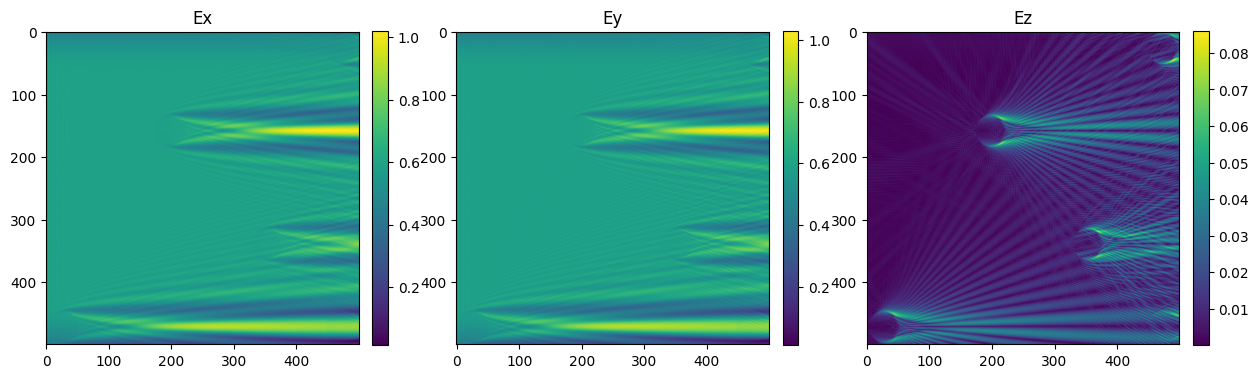

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Ex")
plt.imshow(jnp.rot90(jnp.abs(results.field[results.roi][:, 0, :, 2])))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(jnp.rot90(jnp.abs(results.field[results.roi][:, 0, :, 1])))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Ez")
plt.imshow(jnp.rot90(jnp.abs(results.field[results.roi][:, 0, :, 0])))
plt.colorbar(fraction=0.046, pad=0.04)



# Optimistic fixed point solver

In [8]:
def maxwell_solver_optimistix(
    sample: Sample,
    source: Source,
    tol: float = 1e-3,
    max_steps: int = 250,
    field_init: Array | None = None,
) -> Results:
    # Helper methods
    def fft(x: Array) -> Array:
        return jnp.fft.fftn(x, axes=(0, 1, 2))

    def ifft(x: Array) -> Array:
        return jnp.fft.ifftn(x, axes=(0, 1, 2))

    def pad(field: Array) -> Array:
        return jnp.pad(field, (*padding, (0, 0)))

    def crop(field: Array) -> Array:
        return field[: sample.shape[0], : sample.shape[1], : sample.shape[2], :]

    def calculate_padding(
        shape: tuple[int, ...],
    ) -> tuple[tuple[int, ...], tuple[tuple[int, int], ...]]:
        # Pads to fourier friendly shapes (powers of 2), depending
        # on periodic or absorbing BCs
        # Returns both padded shape and the padding to apply
        def n_pad(size) -> tuple[int, tuple[int, int]]:
            new_size = int(2 ** (np.ceil(np.log2(size))))
            return new_size, (0, new_size - size)

        return tuple(zip(*[n_pad(shape) for shape in shape]))

    # Physical methods
    def G_fn(k: Array, k0: ArrayLike, alpha: Array) -> Array:
        k_sq = jnp.sum(k**2, axis=-1)[..., None, None]
        k_cross = bouter(k, k) / (alpha * k0**2)
        return (jnp.eye(3) - k_cross) / (k_sq - alpha * k0**2)

    def propagate(G: Array, field: Array) -> Array:
        return crop(ifft(bmatvec(G, fft(pad(field)))))

    # Iteration methods
    def update_fn(x: tuple[Array, Array], args) -> tuple[Array, Array]:
        # We split real and imaginary for the field in two
        field = x[0] + 1j * x[1]
        V, source, G = args

        scattered_field = k0**2 * V * field + source
        dE = 1j / alpha_imag * V * (propagate(G, scattered_field) - field)
        field = field + dE
        return field.real, field.imag


    # Calculating background wavenumber and potential
    # We DO NOT want the gradient of alpha - this is something we just calcualte to converge
    # So we stop the gradient - we just want the gradient to flow through V
    alpha_real = stop_gradient(
        (sample.permittivity.real.min() + sample.permittivity.real.max()) / 2
    )
    alpha_imag = stop_gradient(
        jnp.max(jnp.abs(sample.permittivity - alpha_real)) / 0.99
    )
    alpha = alpha_real + 1j * alpha_imag
    V = sample.permittivity[..., None] - alpha

    # We pad to a fourier friendly shape
    padded_shape, padding = calculate_padding(sample.shape)
    k0 = 2 * jnp.pi / source.wavelength
    ks = [2 * jnp.pi * jnp.fft.fftfreq(shape, sample.spacing) for shape in padded_shape]
    k_grid = jnp.stack(jnp.meshgrid(*ks, indexing="ij"), axis=-1)
    G = G_fn(k_grid, k0, alpha)

    if field_init is None:
        field_init = (jnp.zeros(source.source.shape, dtype=jnp.float32), jnp.zeros(source.source.shape, dtype=jnp.float32))
    
    
    results = fixed_point(update_fn, solver=FixedPointIteration(rtol=tol, atol=1e-6), y0=field_init, max_steps=max_steps, args=(V, source.source, G))
    field =  results.value[0] + 1j * results.value[1]
    return Results(field, results.state.relative_error, results.stats["num_steps"], sample.roi)

In [9]:
%%time
results = jax.block_until_ready(maxwell_solver_optimistix(sample, source))

CPU times: user 465 ms, sys: 17 ms, total: 482 ms
Wall time: 675 ms


In [10]:
print(f"Optimistix fixed point solver converged in {results.n_iter} steps." )

Optimistix fixed point solver converged in 95 steps.


In [11]:
%%timeit
# Timing for fixed point optax
_ = jax.block_until_ready(maxwell_solver_optimistix(sample, source))

595 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


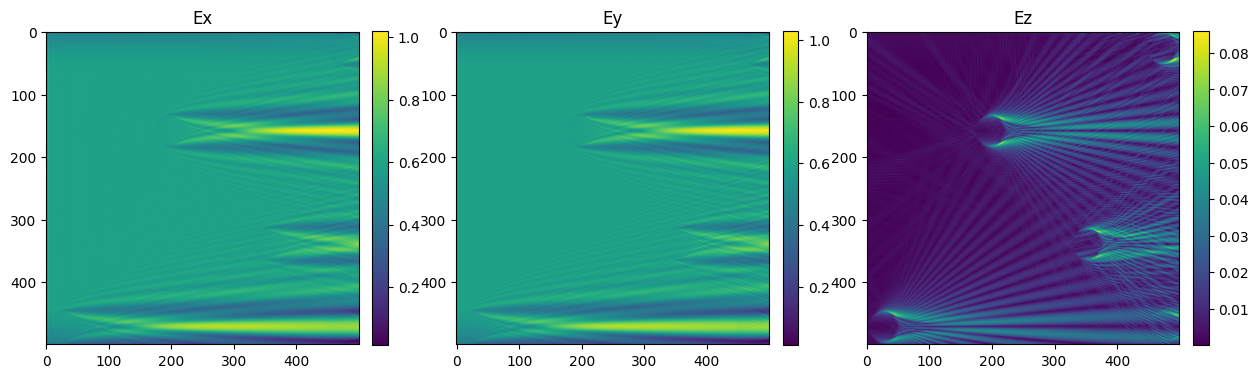

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Ex")
plt.imshow(jnp.rot90(jnp.abs(results.field[results.roi][:, 0, :, 2])))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(jnp.rot90(jnp.abs(results.field[results.roi][:, 0, :, 1])))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Ez")
plt.imshow(jnp.rot90(jnp.abs(results.field[results.roi][:, 0, :, 0])))
plt.colorbar(fraction=0.046, pad=0.04)



# Newton method

In [13]:


def maxwell_solver_newton(
    sample: Sample,
    source: Source,
    tol: float = 1e-3,
    max_steps: int = 250,
    field_init: Array | None = None,
) -> Results:
    # Helper methods
    def fft(x: Array) -> Array:
        return jnp.fft.fftn(x, axes=(0, 1, 2))

    def ifft(x: Array) -> Array:
        return jnp.fft.ifftn(x, axes=(0, 1, 2))

    def pad(field: Array) -> Array:
        return jnp.pad(field, (*padding, (0, 0)))

    def crop(field: Array) -> Array:
        return field[: sample.shape[0], : sample.shape[1], : sample.shape[2], :]

    def calculate_padding(
        shape: tuple[int, ...],
    ) -> tuple[tuple[int, ...], tuple[tuple[int, int], ...]]:
        # Pads to fourier friendly shapes (powers of 2), depending
        # on periodic or absorbing BCs
        # Returns both padded shape and the padding to apply
        def n_pad(size) -> tuple[int, tuple[int, int]]:
            new_size = int(2 ** (np.ceil(np.log2(size))))
            return new_size, (0, new_size - size)

        return tuple(zip(*[n_pad(shape) for shape in shape]))

    # Physical methods
    def G_fn(k: Array, k0: ArrayLike, alpha: Array) -> Array:
        k_sq = jnp.sum(k**2, axis=-1)[..., None, None]
        k_cross = bouter(k, k) / (alpha * k0**2)
        return (jnp.eye(3) - k_cross) / (k_sq - alpha * k0**2)

    def propagate(G: Array, field: Array) -> Array:
        return crop(ifft(bmatvec(G, fft(pad(field)))))

    # Iteration methods
    def update_fn(x: tuple[Array, Array], args) -> tuple[Array, Array]:
        # We split real and imaginary for the field in two
        field = x[0] + 1j * x[1]
        V, source, G = args

        scattered_field = k0**2 * V * field + source
        dE = 1j / alpha_imag * V * (propagate(G, scattered_field) - field)
        field = field + dE
        return field.real, field.imag


    # Calculating background wavenumber and potential
    # We DO NOT want the gradient of alpha - this is something we just calcualte to converge
    # So we stop the gradient - we just want the gradient to flow through V
    alpha_real = stop_gradient(
        (sample.permittivity.real.min() + sample.permittivity.real.max()) / 2
    )
    alpha_imag = stop_gradient(
        jnp.max(jnp.abs(sample.permittivity - alpha_real)) / 0.99
    )
    alpha = alpha_real + 1j * alpha_imag
    V = sample.permittivity[..., None] - alpha

    # We pad to a fourier friendly shape
    padded_shape, padding = calculate_padding(sample.shape)
    k0 = 2 * jnp.pi / source.wavelength
    ks = [2 * jnp.pi * jnp.fft.fftfreq(shape, sample.spacing) for shape in padded_shape]
    k_grid = jnp.stack(jnp.meshgrid(*ks, indexing="ij"), axis=-1)
    G = G_fn(k_grid, k0, alpha)

    if field_init is None:
        field_init = (jnp.zeros(source.source.shape, dtype=jnp.float32), jnp.zeros(source.source.shape, dtype=jnp.float32))
   
    results = fixed_point(update_fn, solver=Newton(rtol=tol, atol=1e-6), y0=field_init, max_steps=max_steps, args=(V, source.source, G))
    field =  results.value[0] + 1j * results.value[1]
    return Results(field, results.state.relative_error, results.stats["num_steps"], sample.roi)

In [14]:
%%time
results = jax.block_until_ready(maxwell_solver_newton(sample, source))

2024-11-13 13:43:46.472326: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 77.25TiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 84934672777216 bytes.

: 

# Root find

In [18]:
def maxwell_solver_rootfind(
    sample: Sample,
    source: Source,
    tol: float = 1e-3,
    max_steps: int = 250,
    field_init: Array | None = None,
) -> Results:
    # Helper methods
    def fft(x: Array) -> Array:
        return jnp.fft.fftn(x, axes=(0, 1, 2))

    def ifft(x: Array) -> Array:
        return jnp.fft.ifftn(x, axes=(0, 1, 2))

    def pad(field: Array) -> Array:
        return jnp.pad(field, (*padding, (0, 0)))

    def crop(field: Array) -> Array:
        return field[: sample.shape[0], : sample.shape[1], : sample.shape[2], :]

    def calculate_padding(
        shape: tuple[int, ...],
    ) -> tuple[tuple[int, ...], tuple[tuple[int, int], ...]]:
        # Pads to fourier friendly shapes (powers of 2), depending
        # on periodic or absorbing BCs
        # Returns both padded shape and the padding to apply
        def n_pad(size) -> tuple[int, tuple[int, int]]:
            new_size = int(2 ** (np.ceil(np.log2(size))))
            return new_size, (0, new_size - size)

        return tuple(zip(*[n_pad(shape) for shape in shape]))

    # Physical methods
    def G_fn(k: Array, k0: ArrayLike, alpha: Array) -> Array:
        k_sq = jnp.sum(k**2, axis=-1)[..., None, None]
        k_cross = bouter(k, k) / (alpha * k0**2)
        return (jnp.eye(3) - k_cross) / (k_sq - alpha * k0**2)

    def propagate(G: Array, field: Array) -> Array:
        return crop(ifft(bmatvec(G, fft(pad(field)))))

    # Iteration methods
    def update_fn(x: tuple[Array, Array], args) -> tuple[Array, Array]:
        # We split real and imaginary for the field in two
        field = x[0] + 1j * x[1]
        V, source, G = args

        scattered_field = k0**2 * V * field + source
        dE = 1j / alpha_imag * V * (propagate(G, scattered_field) - field)
        return dE.real, dE.imag


    # Calculating background wavenumber and potential
    # We DO NOT want the gradient of alpha - this is something we just calcualte to converge
    # So we stop the gradient - we just want the gradient to flow through V
    alpha_real = stop_gradient(
        (sample.permittivity.real.min() + sample.permittivity.real.max()) / 2
    )
    alpha_imag = stop_gradient(
        jnp.max(jnp.abs(sample.permittivity - alpha_real)) / 0.99
    )
    alpha = alpha_real + 1j * alpha_imag
    V = sample.permittivity[..., None] - alpha

    # We pad to a fourier friendly shape
    padded_shape, padding = calculate_padding(sample.shape)
    k0 = 2 * jnp.pi / source.wavelength
    ks = [2 * jnp.pi * jnp.fft.fftfreq(shape, sample.spacing) for shape in padded_shape]
    k_grid = jnp.stack(jnp.meshgrid(*ks, indexing="ij"), axis=-1)
    G = G_fn(k_grid, k0, alpha)

    if field_init is None:
        field_init = (jnp.zeros(source.source.shape, dtype=jnp.float32), jnp.zeros(source.source.shape, dtype=jnp.float32))
   
    results = root_find(update_fn, solver=LevenbergMarquardt(rtol=tol, atol=1e-6), y0=field_init, max_steps=max_steps, args=(V, source.source, G))
    field =  results.value[0] + 1j * results.value[1]
    return Results(field, results.state.relative_error, results.stats["num_steps"], sample.roi)

In [19]:
%%time
results = jax.block_until_ready(maxwell_solver_rootfind(sample, source))

XlaRuntimeError: FAILED_PRECONDITION: Buffer Definition Event: Error preparing computation: %sOut of memory allocating 375890634001872 bytes.

In [10]:
sample.shape

(750, 1, 750)

In [17]:
source.source.shape

(750, 1, 750, 3)

# General minimising

In [21]:
def maxwell_solver_minimise(
    sample: Sample,
    source: Source,
    tol: float = 1e-3,
    max_steps: int = 250,
    field_init: Array | None = None,
) -> Results:
    # Helper methods
    def fft(x: Array) -> Array:
        return jnp.fft.fftn(x, axes=(0, 1, 2))

    def ifft(x: Array) -> Array:
        return jnp.fft.ifftn(x, axes=(0, 1, 2))

    def pad(field: Array) -> Array:
        return jnp.pad(field, (*padding, (0, 0)))

    def crop(field: Array) -> Array:
        return field[: sample.shape[0], : sample.shape[1], : sample.shape[2], :]

    def calculate_padding(
        shape: tuple[int, ...],
    ) -> tuple[tuple[int, ...], tuple[tuple[int, int], ...]]:
        # Pads to fourier friendly shapes (powers of 2), depending
        # on periodic or absorbing BCs
        # Returns both padded shape and the padding to apply
        def n_pad(size) -> tuple[int, tuple[int, int]]:
            new_size = int(2 ** (np.ceil(np.log2(size))))
            return new_size, (0, new_size - size)

        return tuple(zip(*[n_pad(shape) for shape in shape]))

    # Physical methods
    def G_fn(k: Array, k0: ArrayLike, alpha: Array) -> Array:
        k_sq = jnp.sum(k**2, axis=-1)[..., None, None]
        k_cross = bouter(k, k) / (alpha * k0**2)
        return (jnp.eye(3) - k_cross) / (k_sq - alpha * k0**2)

    def propagate(G: Array, field: Array) -> Array:
        return crop(ifft(bmatvec(G, fft(pad(field)))))

    # Iteration methods
    def update_fn(x: tuple[Array, Array], args) -> tuple[Array, Array]:
        # We split real and imaginary for the field in two
        field = x[0] + 1j * x[1]
        V, source, G = args

        scattered_field = k0**2 * V * field + source
        dE = 1j / alpha_imag * V * (propagate(G, scattered_field) - field)
        return jnp.max(jnp.abs(dE)**2)


    # Calculating background wavenumber and potential
    # We DO NOT want the gradient of alpha - this is something we just calcualte to converge
    # So we stop the gradient - we just want the gradient to flow through V
    alpha_real = stop_gradient(
        (sample.permittivity.real.min() + sample.permittivity.real.max()) / 2
    )
    alpha_imag = stop_gradient(
        jnp.max(jnp.abs(sample.permittivity - alpha_real)) / 0.99
    )
    alpha = alpha_real + 1j * alpha_imag
    V = sample.permittivity[..., None] - alpha

    # We pad to a fourier friendly shape
    padded_shape, padding = calculate_padding(sample.shape)
    k0 = 2 * jnp.pi / source.wavelength
    ks = [2 * jnp.pi * jnp.fft.fftfreq(shape, sample.spacing) for shape in padded_shape]
    k_grid = jnp.stack(jnp.meshgrid(*ks, indexing="ij"), axis=-1)
    G = G_fn(k_grid, k0, alpha)

    if field_init is None:
        field_init = (jnp.zeros_like(source.source.real, dtype=jnp.float32), jnp.zeros_like(source.source.imag, dtype=jnp.float32))
   
    results = minimise(update_fn, solver=NonlinearCG(rtol=1e-6, atol=1e-6), y0=field_init, max_steps=max_steps, args=(V, source.source, G))
    field =  results.value[0] + 1j * results.value[1]
    return Results(field, 0.0, results.stats["num_steps"], sample.roi)

In [22]:
%%time
results = jax.block_until_ready(maxwell_solver_minimise(sample, source))

CPU times: user 4.01 s, sys: 136 ms, total: 4.14 s
Wall time: 2.63 s


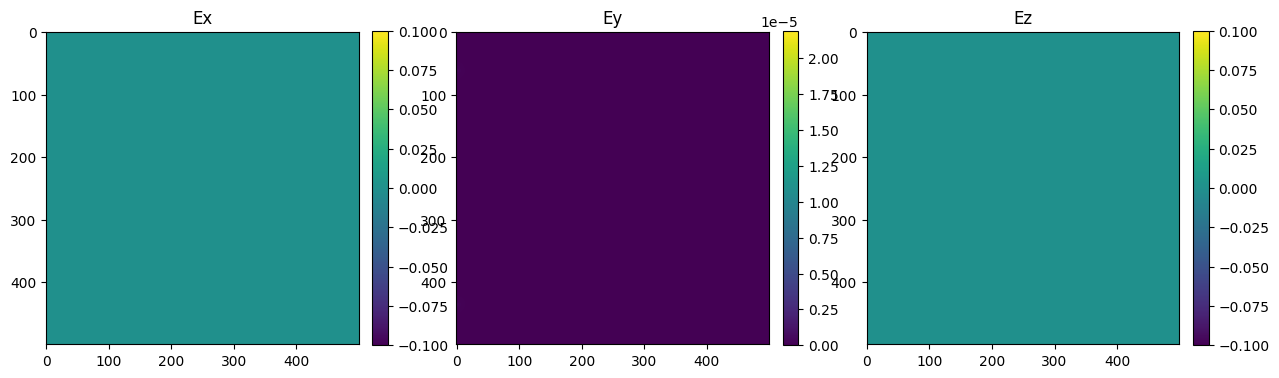

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Ex")
plt.imshow(jnp.rot90(jnp.abs(results.field[results.roi][:, 0, :, 2])))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(jnp.rot90(jnp.abs(results.field[results.roi][:, 0, :, 1])))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Ez")
plt.imshow(jnp.rot90(jnp.abs(results.field[results.roi][:, 0, :, 0])))
plt.colorbar(fraction=0.046, pad=0.04)



# First order optimisers

In [26]:
def maxwell_solver_minimise(
    sample: Sample,
    source: Source,
    tol: float = 1e-3,
    max_steps: int = 250,
    field_init: Array | None = None,
) -> Results:
    # Helper methods
    def fft(x: Array) -> Array:
        return jnp.fft.fftn(x, axes=(0, 1, 2))

    def ifft(x: Array) -> Array:
        return jnp.fft.ifftn(x, axes=(0, 1, 2))

    def pad(field: Array) -> Array:
        return jnp.pad(field, (*padding, (0, 0)))

    def crop(field: Array) -> Array:
        return field[: sample.shape[0], : sample.shape[1], : sample.shape[2], :]

    def calculate_padding(
        shape: tuple[int, ...],
    ) -> tuple[tuple[int, ...], tuple[tuple[int, int], ...]]:
        # Pads to fourier friendly shapes (powers of 2), depending
        # on periodic or absorbing BCs
        # Returns both padded shape and the padding to apply
        def n_pad(size) -> tuple[int, tuple[int, int]]:
            new_size = int(2 ** (np.ceil(np.log2(size))))
            return new_size, (0, new_size - size)

        return tuple(zip(*[n_pad(shape) for shape in shape]))

    # Physical methods
    def G_fn(k: Array, k0: ArrayLike, alpha: Array) -> Array:
        k_sq = jnp.sum(k**2, axis=-1)[..., None, None]
        k_cross = bouter(k, k) / (alpha * k0**2)
        return (jnp.eye(3) - k_cross) / (k_sq - alpha * k0**2)

    def propagate(G: Array, field: Array) -> Array:
        return crop(ifft(bmatvec(G, fft(pad(field)))))

    # Iteration methods
    def update_fn(x: tuple[Array, Array], args) -> tuple[Array, Array]:
        # We split real and imaginary for the field in two
        field = x[0] + 1j * x[1]
        V, source, G = args

        scattered_field = k0**2 * V * field + source
        dE = 1j / alpha_imag * V * (propagate(G, scattered_field) - field)
        return jnp.max(jnp.abs(dE)**2)


    # Calculating background wavenumber and potential
    # We DO NOT want the gradient of alpha - this is something we just calcualte to converge
    # So we stop the gradient - we just want the gradient to flow through V
    alpha_real = stop_gradient(
        (sample.permittivity.real.min() + sample.permittivity.real.max()) / 2
    )
    alpha_imag = stop_gradient(
        jnp.max(jnp.abs(sample.permittivity - alpha_real)) / 0.99
    )
    alpha = alpha_real + 1j * alpha_imag
    V = sample.permittivity[..., None] - alpha

    # We pad to a fourier friendly shape
    padded_shape, padding = calculate_padding(sample.shape)
    k0 = 2 * jnp.pi / source.wavelength
    ks = [2 * jnp.pi * jnp.fft.fftfreq(shape, sample.spacing) for shape in padded_shape]
    k_grid = jnp.stack(jnp.meshgrid(*ks, indexing="ij"), axis=-1)
    G = G_fn(k_grid, k0, alpha)

    if field_init is None:
        field_init = (jnp.zeros_like(source.source.real, dtype=jnp.float32), jnp.zeros_like(source.source.imag, dtype=jnp.float32))
    
    solver = OptaxMinimiser(optax.adabelief(learning_rate=1e-3), rtol=1e-3, atol=1e-6)
    results = minimise(update_fn, solver=solver, y0=field_init, max_steps=max_steps, args=(V, source.source, G))
    field =  results.value[0] + 1j * results.value[1]
    return Results(field, 0.0, results.stats["num_steps"], sample.roi)

In [27]:
%%time
results = jax.block_until_ready(maxwell_solver_minimise(sample, source))

EquinoxRuntimeError: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "/Users/bothg/Documents/optics/chromatix/.venv/lib/python3.10/site-packages/optimistix/_minimise.py", line 107, in minimise
    return iterative_solve(
  File "/Users/bothg/Documents/optics/chromatix/.venv/lib/python3.10/site-packages/optimistix/_iterate.py", line 352, in iterative_solve
    sol = result.error_if(sol, result != RESULTS.successful)
equinox.EquinoxRuntimeError: The maximum number of steps was reached in the nonlinear solver. The problem may not be solveable (e.g., a root-find on a function that has no roots), or you may need to increase `max_steps`.

-------------------

An error occurred during the runtime of your JAX program.

1) Setting the environment variable `EQX_ON_ERROR=breakpoint` is usually the most useful
way to debug such errors. This can be interacted with using most of the usual commands
for the Python debugger: `u` and `d` to move up and down frames, the name of a variable
to print its value, etc.

2) You may also like to try setting `JAX_DISABLE_JIT=1`. This will mean that you can
(mostly) inspect the state of your program as if it was normal Python.

3) See `https://docs.kidger.site/equinox/api/debug/` for more suggestions.


# Jaxopt + anderson

In [38]:
from jaxopt import FixedPointIteration, AndersonAcceleration

def maxwell_solver_anderson(
    sample: Sample,
    source: Source,
    rtol: float = 1e-6,
    max_iter: int = 1000,
    field_init: Array | None = None,
) -> Results:
    # Helper methods
    def fft(x: Array) -> Array:
        return jnp.fft.fftn(x, axes=(0, 1, 2))

    def ifft(x: Array) -> Array:
        return jnp.fft.ifftn(x, axes=(0, 1, 2))

    def pad(field: Array) -> Array:
        return jnp.pad(field, (*padding, (0, 0)))

    def crop(field: Array) -> Array:
        return field[: sample.shape[0], : sample.shape[1], : sample.shape[2], :]

    def calculate_padding(
        shape: tuple[int, ...],
    ) -> tuple[tuple[int, ...], tuple[tuple[int, int], ...]]:
        # Pads to fourier friendly shapes (powers of 2), depending
        # on periodic or absorbing BCs
        # Returns both padded shape and the padding to apply
        def n_pad(size) -> tuple[int, tuple[int, int]]:
            new_size = int(2 ** (np.ceil(np.log2(size))))
            return new_size, (0, new_size - size)

        return tuple(zip(*[n_pad(shape) for shape in shape]))

    # Physical methods
    def G_fn(k: Array, k0: ArrayLike, alpha: Array) -> Array:
        k_sq = jnp.sum(k**2, axis=-1)[..., None, None]
        k_cross = bouter(k, k) / (alpha * k0**2)
        return (jnp.eye(3) - k_cross) / (k_sq - alpha * k0**2)

    def propagate(G: Array, field: Array) -> Array:
        return crop(ifft(bmatvec(G, fft(pad(field)))))

    # Iteration methods
    def update_fn(
        x: tuple[Array, Array], V: Array, source: Array, G: Array
    ) -> tuple[Array, dict[str, Array]]:
        field = x[0] + 1j * x[1]
        scattered_field = k0**2 * V * field + source
        dE = 1j / alpha_imag * V * (propagate(G, scattered_field) - field)

        field = field + dE
        return (field.real, field.imag)

    # Calculating background wavenumber and potential
    # We DO NOT want the gradient of alpha - this is something we just calcualte to converge
    # So we stop the gradient - we just want the gradient to flow through V
    alpha_real = stop_gradient(
        (sample.permittivity.real.min() + sample.permittivity.real.max()) / 2
    )
    alpha_imag = stop_gradient(
        jnp.max(jnp.abs(sample.permittivity - alpha_real)) / 0.99
    )
    alpha = alpha_real + 1j * alpha_imag
    V = sample.permittivity[..., None] - alpha

    # We pad to a fourier friendly shape
    padded_shape, padding = calculate_padding(sample.shape)
    k0 = 2 * jnp.pi / source.wavelength
    ks = [2 * jnp.pi * jnp.fft.fftfreq(shape, sample.spacing) for shape in padded_shape]
    k_grid = jnp.stack(jnp.meshgrid(*ks, indexing="ij"), axis=-1)
    G = G_fn(k_grid, k0, alpha)

    if field_init is None:
        field_init = (jnp.zeros_like(source.source, dtype=jnp.float32), jnp.zeros_like(source.source, dtype=jnp.float32))
        
    solver = AndersonAcceleration(update_fn, maxiter=max_iter, tol=rtol)
    results = solver.run(field_init, V=V, source=source.source, G=G)

    return Results(
        results.params[0] + 1j * results.params[1], results.state.error, results.state.iter_num, sample.roi
    )

In [39]:
%%time
results = jax.block_until_ready(maxwell_solver_anderson(sample, source, max_iter=250, rtol=1e-3))

CPU times: user 8.56 s, sys: 321 ms, total: 8.88 s
Wall time: 5.95 s


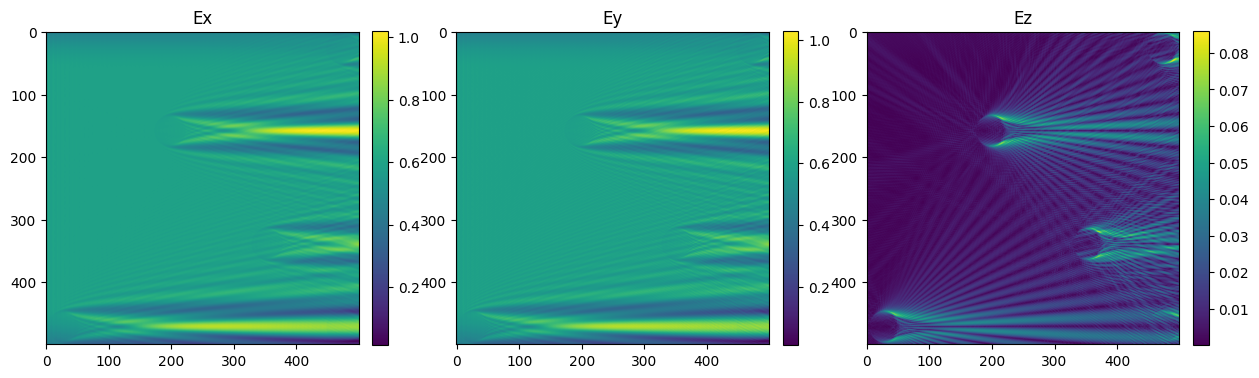

In [40]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Ex")
plt.imshow(jnp.rot90(jnp.abs(results.field[results.roi][:, 0, :, 2])))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(jnp.rot90(jnp.abs(results.field[results.roi][:, 0, :, 1])))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Ez")
plt.imshow(jnp.rot90(jnp.abs(results.field[results.roi][:, 0, :, 0])))
plt.colorbar(fraction=0.046, pad=0.04)

